# Graph Convolutional Networks (GCN)

Most of the explanations of this notebook are taken from the following sources:
* [Thomas Kipf, Graph Convolutional Networks](https://tkipf.github.io/graph-convolutional-networks/)
* [Kipf et al. Semi-Supervised classification with graph convolutional networks](https://arxiv.org/pdf/1609.02907.pdf)

## Definitions

Given a graph $\mathcal{G}=(\mathcal{V}, \mathcal{E})$ We want to learn a function $f$ which takes as input:

* A feature description $x_i$ for every node $i$; summarized in a $N×D$ feature matrix $X$ ($N$: number of nodes, $D$: number of input features)
* A representative description of the graph structure in matrix form; typically in the form of an adjacency matrix $A$ (or some function thereof)

and outputs:

* a node-level output $Z$ (an $N×F$ feature matrix, where $F$ is the number of output features per node)

$$
f(X, A) = Z
$$

If we generalize to a general neural-network layer:
$$
    H^{(l+1)} = f(H^{(l)}, A) \quad H^{(0)} = X \quad H^{(L)} = Z
$$

In [Kipf et al. 2016](https://arxiv.org/pdf/1609.02907.pdf) they propose the following layer propagation rule:

$$
f(H^{(l)}, A) = \sigma\left( \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H^{(l)}W^{(l)}\right) \,
$$

with:

* $\hat{A} = A + I$
* $\hat{D}$ is the diagonal node degree matrix of $\hat{A}$
* $W^{(l)}$ is the weight matrix for layer $l$
* $\sigma$ is a non-linear activation function (like ReLu or tanh)

In [1]:
import numpy as np
import networkx
import community
import matplotlib.pyplot as plt
import seaborn as sns

## Example: classifying the Zachary's karate club network

In [2]:
G = networkx.karate_club_graph()

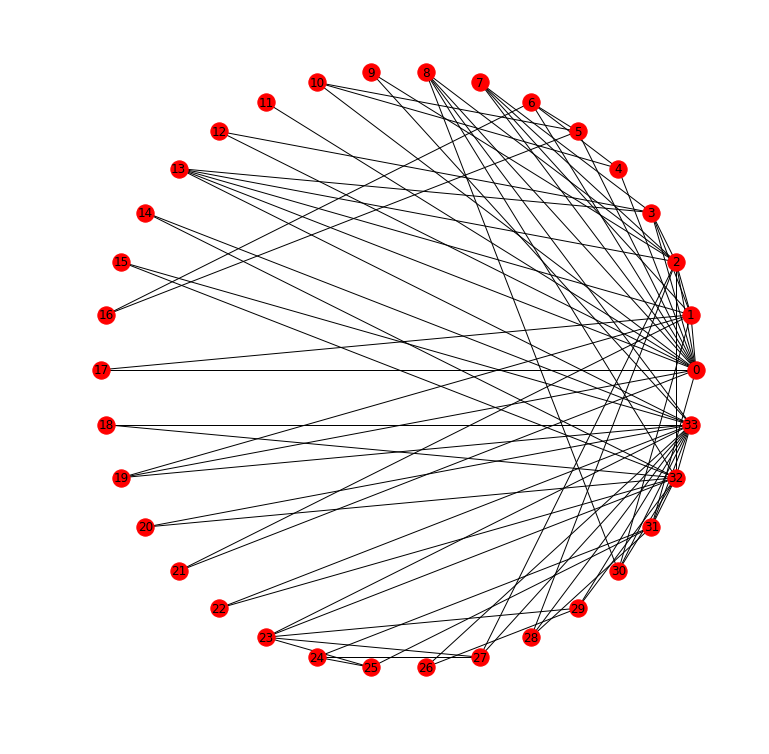

In [3]:
plt.figure(figsize=(10, 10))
networkx.draw_circular(G, with_labels=True)
plt.show()

### Modularity-based clustering of the network

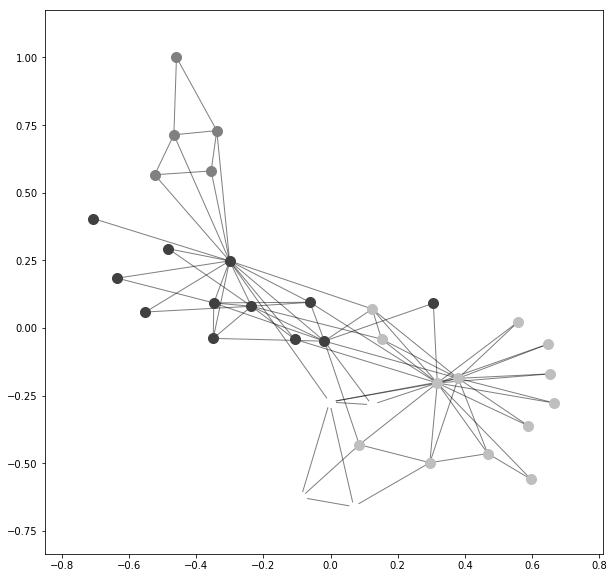

In [4]:
#first compute the best partition
partition = community.best_partition(G)
plt.figure(figsize=(10, 10))
#drawing
size = float(len(set(partition.values())))
pos = networkx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    networkx.draw_networkx_nodes(G, pos, list_nodes, node_size = 100, label=True,
                                node_color = str(count / size))


networkx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Using an un-trained GCN to clusterize the nodes

In [5]:
# input matrix
X = np.identity(G.number_of_nodes())

# adjacency matrix
A = networkx.adjacency_matrix(G)

# augmented adjacency matrix (and graph)
A_tilde = np.identity(A.shape[0]) + A.toarray()
G_tilde = networkx.from_numpy_matrix(A_tilde)

# degree matrix of augmented adjacency matrix
degrees = networkx.degree(G_tilde)
D_tilde = []

for node in range(G_tilde.number_of_nodes()):
    D_tilde.append(degrees[node])
D_tilde = np.diag(D_tilde)

A_cap = np.sqrt(np.linalg.inv(D_tilde)).dot(A_tilde).dot(np.sqrt(np.linalg.inv(D_tilde)))

In [6]:
def glorot(shape):
    init_range = np.sqrt(6.0/(shape[0]+shape[1]))
    initial = np.random.uniform(low=-init_range, high=init_range, size=shape)
    return initial

def ReLu(x):
    return np.multiply(x, x>0)

def layerOp(H, W):
    return np.tanh(A_cap.dot(H).dot(W))

In [7]:
W_0 = glorot((X.shape[1], 4))
W_1 = glorot((4, 4))
W_2 = glorot((4, 2))

In [8]:
H_0 = X
H_1 = layerOp(H_0, W_0)
H_2 = layerOp(H_1, W_1)
Z = layerOp(H_2, W_2)

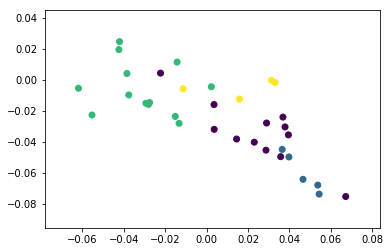

In [9]:
plt.figure()
plt.scatter(Z[:, 0], Z[:, 1], c=list(partition.values()))
plt.show()